In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
from pyresample.geometry import AreaDefinition
from pyresample.geometry import SwathDefinition
from pyresample import kd_tree
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from evaluation.metrics import *
import cmcrameri

# Transform data

In [2]:
path = "../../data/application/"

In [3]:
# Define original area
projection = "+proj=lcc +lat_1=35 +lat_2=65 +lat_0=52 +lon_0=10 +x_0=4000000 +y_0=2800000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
width = 1200
height = 1100
area_extent = (3500000, 2100000, 4700000, 3200000)
area_def = AreaDefinition('original', 'Original grid', 'id', projection,width, height, area_extent)

# Define target grid
lons = np.linspace(6.38,7.48,30)
lats = np.linspace(50.27,50.97,30)
lon2d, lat2d = np.meshgrid(lons, lats)
target_grid = SwathDefinition(lons = lon2d, lats = lat2d)

In [4]:
# Functions for projection, interpolation and monthly maximum

def downsample(data, area_def, target_grid):
    result = kd_tree.resample_nearest(
        area_def, data, target_grid, radius_of_influence=50000, epsilon=0.5
    )
    return result


def xr_downsample(data, area_def, target_grid):
    result = xr.apply_ufunc(
        downsample,
        data,
        area_def,
        target_grid,
        input_core_dims=[["y", "x", "time"], [], []],
        output_core_dims=[["y", "x", "time"]],
        exclude_dims=set(("x", "y")),
        vectorize = True,
        dask = "allowed"
    )
    return result.max(dim = ["time"])


def transform_data(data, area_def, target_grid, year = ""):
    transformed_data = data.resample(time = "1MS").apply(xr_downsample, args = (area_def, target_grid))
    transformed_data = transformed_data.isel(time=(transformed_data.time.dt.month.isin([6,7,8])))
    xr.Dataset({"pr":transformed_data}).to_netcdf(f"../../data/application/{year}_month_max.nc")

In [5]:
# Training data
raw_data = xr.open_dataset(path + "1931_2020_raw.nc")
data = raw_data.pr.isel(time=(raw_data.time.dt.month.isin([6,7,8])))
transform_data(data, area_def, target_grid, year = "1931_2020")

# 2021
raw_data = xr.open_dataset(path + "2021_raw.nc")
data = raw_data.pr.isel(time=(raw_data.time.dt.month.isin([6,7,8])))
transform_data(data, area_def, target_grid, year = "2021")

# 2022
raw_data = xr.open_dataset(path + "2022_raw.nc")
data = raw_data.pr.isel(time=(raw_data.time.dt.month.isin([6,7,8])))
transform_data(data, area_def, target_grid, year = "2022")

# 2023
raw_data = xr.open_dataset(path + "2023_raw.nc")
data = raw_data.pr.isel(time=(raw_data.time.dt.month.isin([6,7,8])))
transform_data(data, area_def, target_grid, year = "2023")

# Prepare data for CNN

In [4]:
gev_params = {
    "loc1": 64.799623725,
    "loc_lat": -0.999680643,
    "loc_lon": 0.014852714,
    "loc_time": 0.001105532,
    "scale": 7.004518221,
    "shape": 0.105249698,
}

In [5]:
def gev2frech(data, year):
    # Define lat lon grid
    lons = np.linspace(6.38, 7.48, 30)
    lats = np.linspace(50.27, 50.97, 30)
    lon2d, lat2d = np.meshgrid(lons, lats)

    # Define year
    year_emb = year - 1931 + 1

    # Calculate parameters
    mu = (
        gev_params["loc1"]
        + lat2d * gev_params["loc_lat"]
        + lat2d * gev_params["loc_lon"]
        + year_emb * gev_params["loc_time"]
    )
    sigma = gev_params["scale"]
    gamma = gev_params["shape"]

    # Transformation
    result = np.power(1 + gamma * (data - mu) / sigma, (1 / gamma))

    return result


In [7]:
path = "../data/application/data/"

# Load test data
data_2021 = gev2frech(xr.open_dataset(path + "2021_month_max.nc"), year = 2021)
data_2022 = gev2frech(xr.open_dataset(path + "2022_month_max.nc"), year = 2022)
data_2023 = gev2frech(xr.open_dataset(path + "2023_month_max.nc"), year = 2023)
data = xr.concat([data_2021, data_2022, data_2023], dim = "time")

# Save data
np.save(path + "brown_test_data.npy",data.pr.data)
np.save(path + "powexp_test_data.npy",data.pr.data)


# Load predictions

In [74]:
plt.style.use('seaborn-v0_8')
cmap_name = "cmc.roma_r"
cmap = plt.get_cmap(cmap_name)
colors = [cmap(x) for x in np.linspace(0.1,0.99,9)]
labels = ["June 2021", "July 2021", "August 2021", "June 2022", "July 2022", "August 2022", "June 2023", "July 2023", "August 2023"]

In [75]:
model = "brown"
cnn = np.load(f"../data/application/results/{model}_cnn.npy")
cnn_es = np.load(f"../data/application/results/{model}_cnn_es.npy")

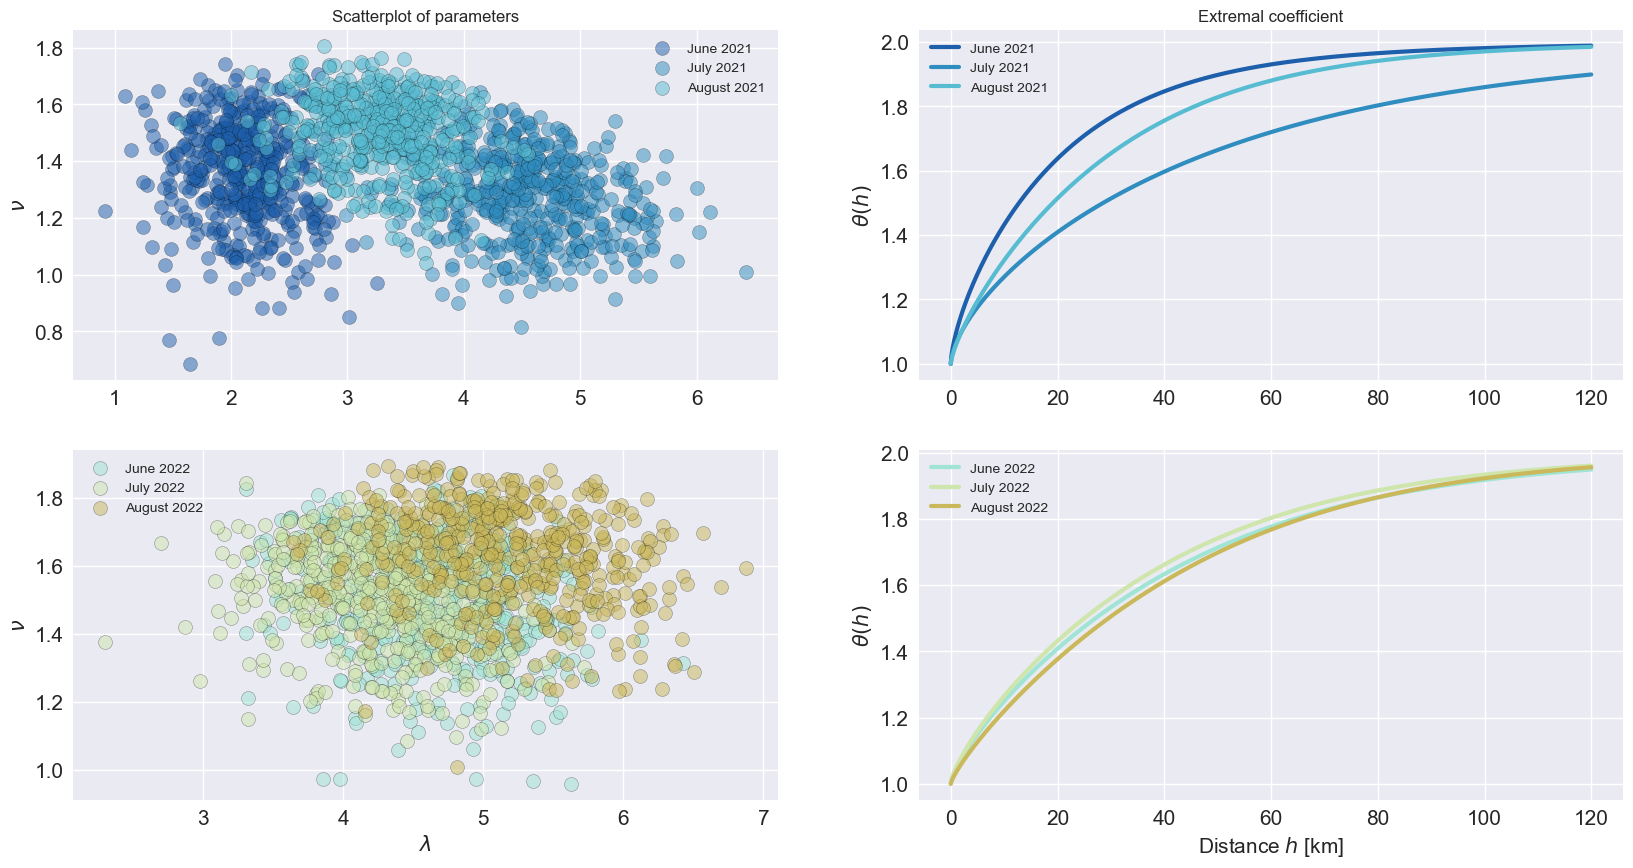

In [76]:
h = np.linspace(0,30,1000)
h_plot = h *4

fig, axs = plt.subplots(2,2, figsize = (20,10))
axs = np.transpose(axs).ravel()

for i in range(3):
    #Mean values
    axs[0].scatter(x = cnn_es[i,0], y = cnn_es[i,1], s = 100, edgecolor = "black", color = colors[i], label = labels[i], alpha = 0.5)
    #axs[0].set_xlabel(r"$\lambda$", fontsize = 15)
    axs[0].set_ylabel(r"$\nu$", fontsize = 15)
    axs[0].tick_params(axis='both', labelsize=15)
   # axs[0].set_xlim([1.5,9])
   # axs[0].set_ylim([0.8,2])
    axs[0].legend()
    axs[0].set_title("Scatterplot of parameters")

for i in range(3,6):
    #Mean values
    axs[1].scatter(x = cnn_es[i,0], y = cnn_es[i,1], s = 100, edgecolor = "black", color = colors[i], label = labels[i], alpha = 0.5)
    axs[1].set_xlabel(r"$\lambda$", fontsize = 15)
    axs[1].set_ylabel(r"$\nu$", fontsize = 15)
    axs[1].tick_params(axis='both', labelsize=15)
   # axs[1].set_xlim([1.5,9])
   # axs[1].set_ylim([0.8,2])
    axs[1].legend()
    #axs[1].set_title("2022")



for i in range(3):
    axs[2].plot(h_plot, sample_extremal_coefficient(h, model, cnn_es[i,0], cnn_es[i,1]), lw = 3, label = labels[i], color = colors[i])
    #axs[2].set_xlabel(r"$h$", fontsize = 15)
    axs[2].set_ylabel(r"$\theta(h)$", fontsize = 15)
    axs[2].tick_params(axis='both', labelsize=15)
    axs[2].legend()
    axs[2].set_title("Extremal coefficient")

for i in range(3,6):
    axs[3].plot(h_plot, sample_extremal_coefficient(h, model, cnn_es[i,0], cnn_es[i,1]), lw = 3, label = labels[i], color = colors[i])
    axs[3].set_xlabel("Distance $h$ [km]", fontsize = 15)
    axs[3].set_ylabel(r"$\theta(h)$", fontsize = 15)
    axs[3].tick_params(axis='both', labelsize=15)
    axs[3].legend()
    #axs[3].set_title("2022")

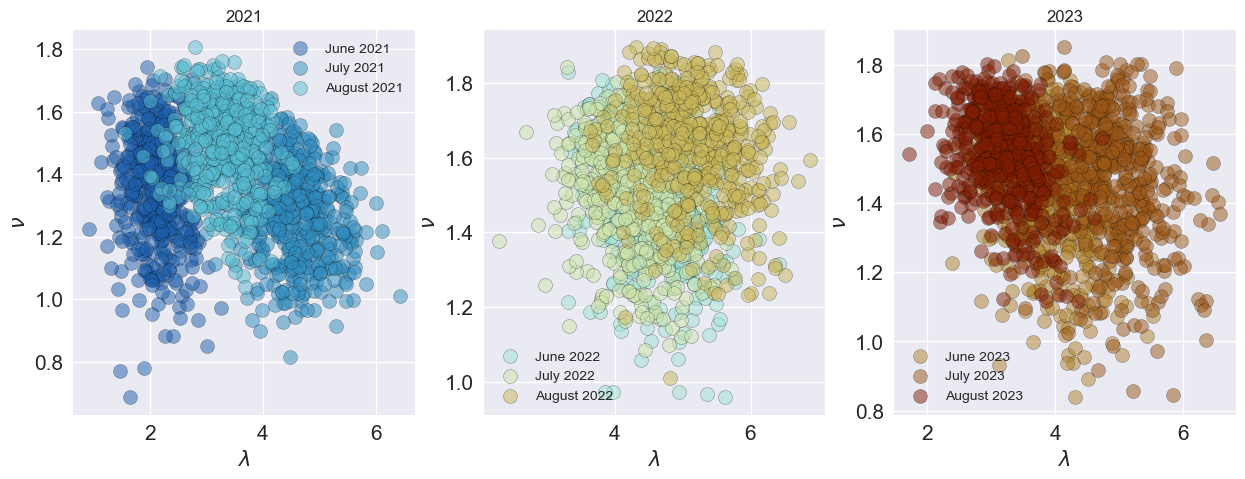

In [77]:
fig, axs = plt.subplots(1,3, figsize = (15,5))

for i in range(3):
    #Mean values
    axs[0].scatter(x = cnn_es[i,0], y = cnn_es[i,1], s = 100, edgecolor = "black", color = colors[i], label = labels[i], alpha = 0.5)
    axs[0].set_xlabel(r"$\lambda$", fontsize = 15)
    axs[0].set_ylabel(r"$\nu$", fontsize = 15)
    axs[0].tick_params(axis='both', labelsize=15)
    axs[0].legend()
    axs[0].set_title("2021")

for i in range(3,6):
    #Mean values
    axs[1].scatter(x = cnn_es[i,0], y = cnn_es[i,1], s = 100, edgecolor = "black", color = colors[i], label = labels[i], alpha = 0.5)
    axs[1].set_xlabel(r"$\lambda$", fontsize = 15)
    axs[1].set_ylabel(r"$\nu$", fontsize = 15)
    axs[1].tick_params(axis='both', labelsize=15)
    axs[1].legend()
    axs[1].set_title("2022")


for i in range(6,9):
    #Mean values
    axs[2].scatter(x = cnn_es[i,0], y = cnn_es[i,1], s = 100, edgecolor = "black", color = colors[i], label = labels[i], alpha = 0.5)
    axs[2].set_xlabel(r"$\lambda$", fontsize = 15)
    axs[2].set_ylabel(r"$\nu$", fontsize = 15)
    axs[2].tick_params(axis='both', labelsize=15)
    axs[2].legend()
    axs[2].set_title("2023")

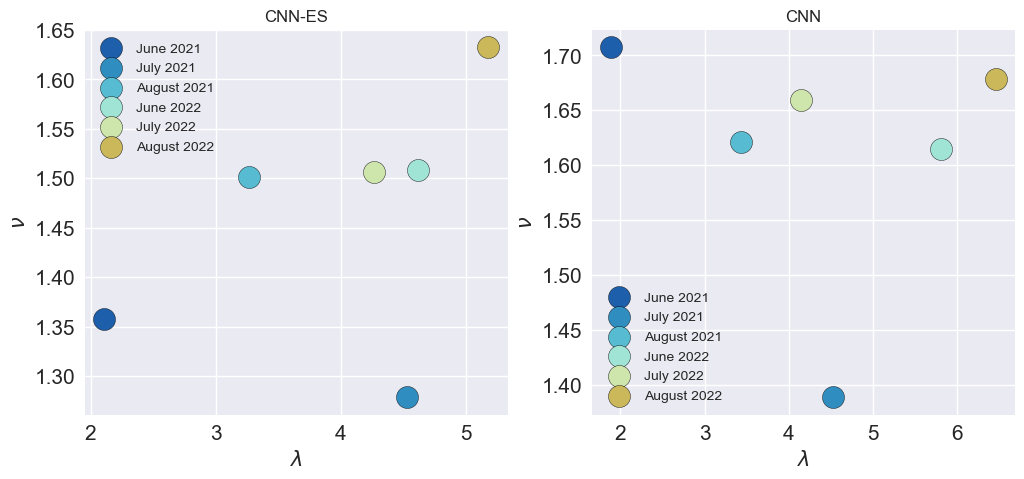

In [78]:
fig, axs = plt.subplots(1,2,figsize = (12,5))


for i in range(6):
    #Mean values
    axs[0].scatter(x = cnn_es[i,0].mean(), y = cnn_es[i,1].mean(), s = 250, edgecolor = "black", label = labels[i], color = colors[i])
    axs[0].set_xlabel(r"$\lambda$", fontsize = 15)
    axs[0].set_ylabel(r"$\nu$", fontsize = 15)
    axs[0].tick_params(axis='both', labelsize=15)
    axs[0].legend()
    axs[0].set_title("CNN-ES")

    #Mean values
    axs[1].scatter(x = cnn[i,0], y = cnn[i,1], s = 250, edgecolor = "black", label = labels[i], color = colors[i])
    axs[1].set_xlabel(r"$\lambda$", fontsize = 15)
    axs[1].set_ylabel(r"$\nu$", fontsize = 15)
    axs[1].tick_params(axis='both', labelsize=15)
    axs[1].legend()
    axs[1].set_title("CNN")

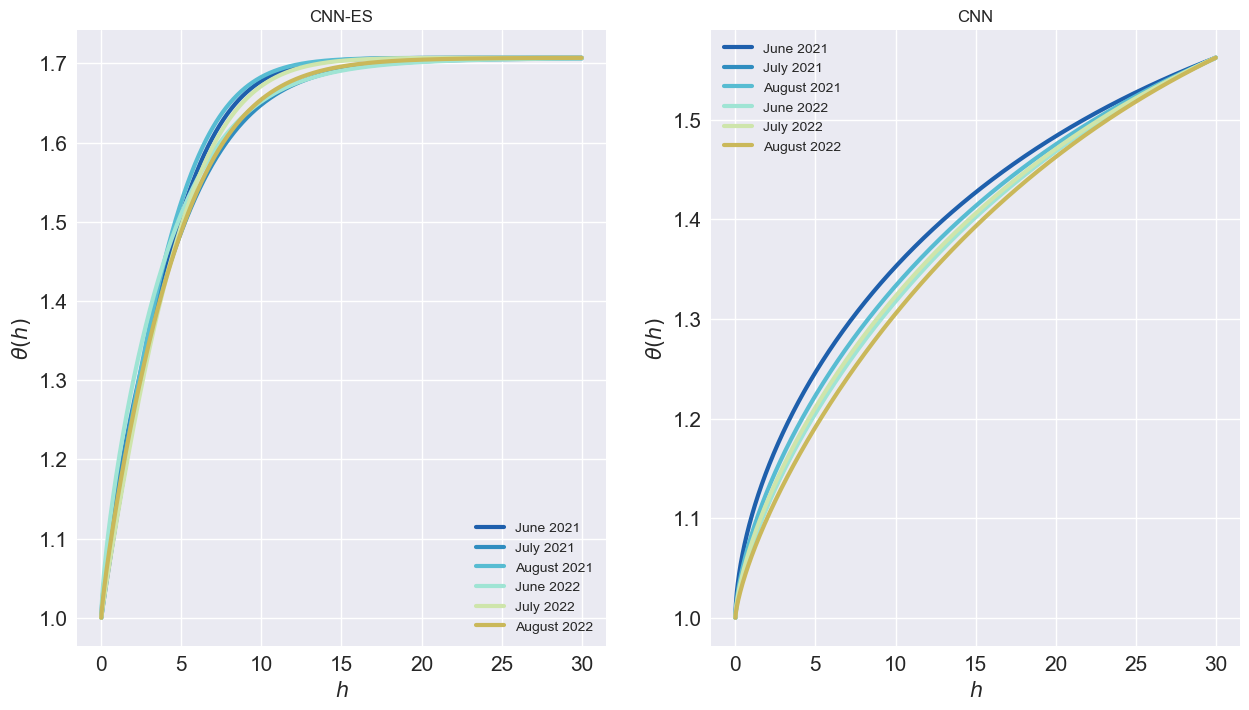

In [104]:
h = np.linspace(0,30,1000)
fig, axs = plt.subplots(1,2, figsize = (15,8))

for i in range(6):
    axs[0].plot(h, sample_extremal_coefficient(h, model, cnn_es[i,0], cnn_es[i,1]), lw = 3, label = labels[i], color = colors[i])
    axs[0].set_xlabel(r"$h$", fontsize = 15)
    axs[0].set_ylabel(r"$\theta(h)$", fontsize = 15)
    axs[0].tick_params(axis='both', labelsize=15)
    axs[0].legend()
    axs[0].set_title("CNN-ES")

    axs[1].plot(h, extremal_coefficient(h, model, cnn[i,0], cnn[i,1]), lw = 3, label = labels[i], color = colors[i])
    axs[1].set_xlabel(r"$h$", fontsize = 15)
    axs[1].set_ylabel(r"$\theta(h)$", fontsize = 15)
    axs[1].tick_params(axis='both', labelsize=15)
    axs[1].legend()
    axs[1].set_title("CNN")

## Madogram estimate

In [98]:
model = "powexp"
cnn = np.load(f"../data/application/results/{model}_cnn.npy")
cnn_es = np.load(f"../data/application/results/{model}_cnn_es.npy")

In [99]:
def frechet_margins(x):
    return np.exp(- 1/x)

def f_madogram(z1, z2):
    n = len(z1)
    return 1/(2*n)*np.sum((np.abs(frechet_margins(z1) - frechet_margins(z2))))

In [100]:
path = "../data/application/data/"

# Load test data
data_prev = xr.open_dataset(path + "1931_2020_month_max.nc").isel(time = slice(240, 270))
for year in range(2011, 2021):
    data_prev.loc[dict(time = str(year))] = gev2frech(data_prev.loc[dict(time = str(year))], year = year)
data_2021 = gev2frech(xr.open_dataset(path + "2021_month_max.nc"), year = 2021)
data_2022 = gev2frech(xr.open_dataset(path + "2022_month_max.nc"), year = 2022)
data_2023 = gev2frech(xr.open_dataset(path + "2023_month_max.nc"), year = 2023)
data_full = xr.concat([data_2021, data_2022, data_2023], dim = "time")
grid = xr.open_dataset("../../data/application/" + "grid.nc").grid.data

#Test
test = data_full.pr.data.reshape((data_full.time.shape[0], -1))

In [101]:
n_sim = 300000
result = np.zeros(shape = (n_sim,2))

for i in range(n_sim):
    sample = np.random.choice(np.arange(0,900), size = 2, replace = False)
    h = np.sqrt(np.sum(np.power(grid[:,sample[0]] - grid[:,sample[1]],2)))
    vf = f_madogram(test[:,sample[0]:sample[0]+1], test[:,sample[1]:sample[1]+1])
    result[i,0] = h
    result[i,1] = (1 +2*vf)/(1-2*vf)


In [102]:
bins = np.linspace(1,35,10000)
ind = np.digitize(result[:,0], bins)
bin_means = np.array([result[ind == i,1].mean() for i in range(len(bins))])

C:\Users\chris\AppData\Local\Temp\ipykernel_22508\1172335667.py:3: RuntimeWarning: Mean of empty slice.
  bin_means = np.array([result[ind == i,1].mean() for i in range(len(bins))])
c:\Users\chris\anaconda3\envs\ma\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(1.0, 2.0)

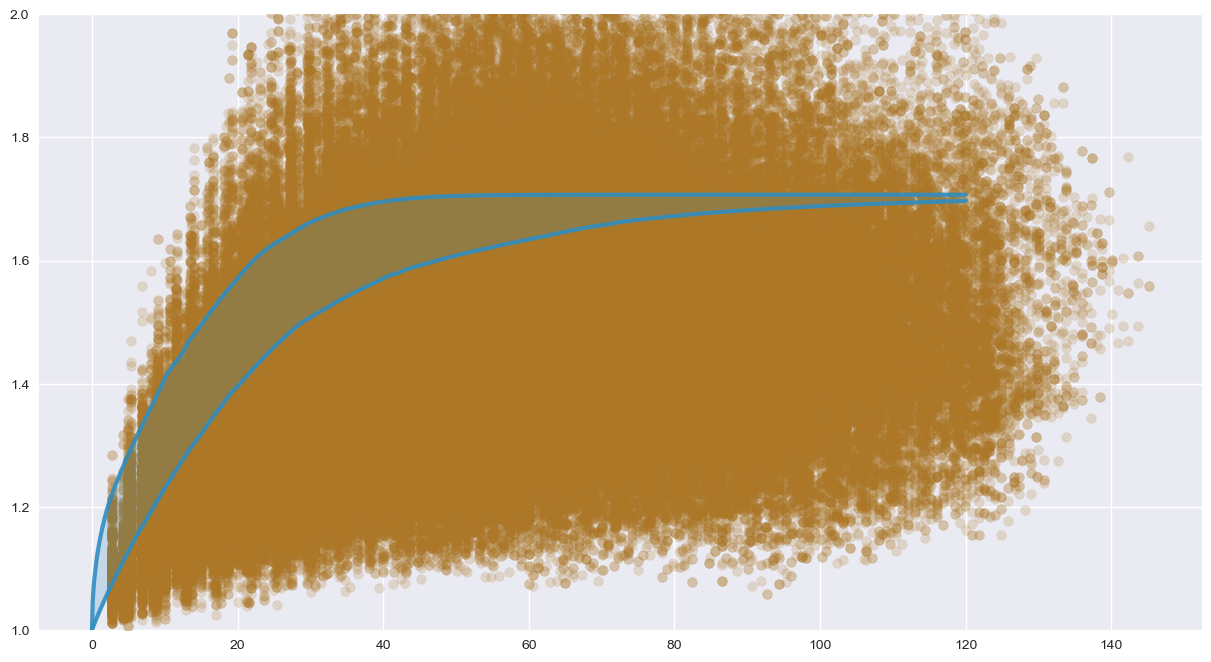

In [103]:
h = np.linspace(0,30,1000)
h_plot = h *4
fig, axs = plt.subplots( figsize = (15,8))

month = 1

axs.scatter(result[:,0]*4, result[:,1], alpha = 0.2, color = cmap(0.8))


#axs.plot(h_plot, sample_extremal_coefficient(h, model, cnn_es[month,0], cnn_es[month,1]), lw = 3, label = labels[i], color = colors[month])
quantiles = np.quantile(sample_extremal_coefficient(h, model, cnn_es[month,0], cnn_es[month,1],  mean = False), q = [0.025,0.975], axis = 0)

axs.plot(h_plot, quantiles[0], color = colors[month], lw = 3, alpha = .9)
axs.plot(h_plot, quantiles[1], color = colors[month], lw = 3, alpha = .9)
axs.fill_between(h_plot, quantiles[0], quantiles[1], color = colors[month], alpha=.2)



axs.set_ylim([1,2])